In [25]:
import json
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from ragas.metrics import RougeScore, BleuScore, ExactMatch, StringPresence
from ragas.metrics._string import NonLLMStringSimilarity
from ragas.evaluation import EvaluationDataset, evaluate
from ragas.dataset_schema import SingleTurnSample
import pandas as pd
import os
import matplotlib.pyplot as plt

In [26]:
def bert_base_turkish_squad(rag_model_name):
    # Modeli yükleme
    tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-squad")
    model = AutoModelForQuestionAnswering.from_pretrained("savasy/bert-base-turkish-squad")
    qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

    # JSON dosyasını yükleme
    input_path = f"./RAG Model Çıktıları/{rag_model_name}_updated_answers.json"
    with open(input_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    # Tahminleri ve sonuçları toplama
    results = []
    for item in data["results"]:
        # Context'i birleştirme
        context = item["model_answer"]
        question = item["question"]
        real_answer = item["real_answer"]

        # Modelden cevap tahmini
        try:
            model_prediction = qa_pipeline(question=question, context=context)
            model_answer = model_prediction["answer"]
        except Exception as e:
            model_answer = f"Model tahmin edemedi: {e}"

        # Sonuçları kaydetme
        results.append({
            "context": item["model_answer"],
            "question": question,
            "real_answer": real_answer,
            "model_answer": model_answer
        })

    # Sonuçları updated_answers dosyasına yazma
    output_path = f"./RAG Modelleri & bert-base-turkish-squad/{rag_model_name}_updated_answers.json"
    with open(output_path, "w", encoding="utf-8") as outfile:
        json.dump({"results": results}, outfile, ensure_ascii=False, indent=4)

    print(f"Cevaplar '{output_path}' dosyasına yazıldı.")

In [27]:
def ragas_metric_calculation(model_name):

    # OpenAI API anahtarını ayarlama
    os.environ["OPENAI_API_KEY"] = "" #Kendi API key'iniz ile doldurun.

    # JSON dosyasını yükleme
    with open(f"./RAG Modelleri & bert-base-turkish-squad/{model_name}_updated_answers.json", "r", encoding="utf-8") as f:
        data = json.load(f)

    # Veri örneklerini JSON'dan SingleTurnSample formatına dönüştürme
    samples = [
        SingleTurnSample(
            user_input=item["question"],
            retrieved_contexts=[" ".join(item["context"])],  # Context listesi birleştirilir
            response=item["model_answer"],
            reference=item["real_answer"]
        )
        for item in data["results"]
    ]

    # Değerlendirme veri setini oluşturma
    dataset = EvaluationDataset(samples=samples)

    # Değerlendirmeyi gerçekleştirme
    results = evaluate(dataset, metrics=[RougeScore(), BleuScore(), ExactMatch(), StringPresence(),NonLLMStringSimilarity()])

    # Sonuçları analiz etme
    df = results.to_pandas()
    display(df.head())  # İlk birkaç sonucu ekrana yazdırma

    # Sonuçları bir CSV dosyasına kaydetme (isteğe bağlı)
    output_path = f"./RAG Modelleri & bert-base-turkish-squad/{model_name}_ragas_evaluation_results.csv"
    df.to_csv(output_path, index=False)
    print(f"Sonuçlar '{output_path}' dosyasına kaydedildi.")

In [28]:
scores = {
    "model": [],
    "bleu": [],
    "rouge": [],
    "exact_match": [],
    "string_present": [],
    "string_similarity": []
    }

def average_ragas_scores(model_name):
    # CSV dosyasını okuma
    file_path = f"./RAG Modelleri & bert-base-turkish-squad/{model_name}_ragas_evaluation_results.csv"  # Dosya adınızı buraya yazın
    df = pd.read_csv(file_path)

    # Ortalama BLEU ve ROUGE skorlarını hesaplama
    average_bleu = df["bleu_score"].mean()
    average_rouge = df["rouge_score"].mean()
    average_exact_match = df["exact_match"].mean()
    average_string_present = df["string_present"].mean()
    average_non_llm_string_similarity = df["non_llm_string_similarity"].mean()

    scores["model"].append(model_name)
    scores["bleu"].append(average_bleu)
    scores["rouge"].append(average_rouge)
    scores["exact_match"].append(average_exact_match)
    scores["string_present"].append(average_string_present)
    scores["string_similarity"].append(average_non_llm_string_similarity)

    # Sonuçları yazdırma
    print(f"Ortalama BLEU Skoru: {average_bleu:.3f}")
    print(f"Ortalama ROUGE Skoru: {average_rouge:.3f}")
    print(f"Ortalama Exact Match Skoru: {average_exact_match:.3f}")
    print(f"Ortalama String Present Skoru: {average_string_present:.3f}")
    print(f"Ortalama String Similarity Skoru: {average_non_llm_string_similarity:.3f}")

In [29]:
rag_models = [
    "jinaaijina-colbert-v2",
    "ytu-ce-cosmosturkish-colbert",
    "andreascharicolbert-xm-lt-cafr"
]

for rag_model in rag_models:
    bert_base_turkish_squad(rag_model)
    print(f"\n\n{rag_model} modeline ait RAGAS ölçüm sonuçları aşağıdaki gibidir.")
    ragas_metric_calculation(rag_model)
    print(f"\n\n{rag_model} modeline ait ortalama RAGAS ölçüm sonuçları aşağıdaki gibidir.")
    average_ragas_scores(rag_model)

Some weights of the model checkpoint at savasy/bert-base-turkish-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Cevaplar './RAG Modelleri & bert-base-turkish-squad/jinaaijina-colbert-v2_updated_answers.json' dosyasına yazıldı.


jinaaijina-colbert-v2 modeline ait RAGAS ölçüm sonuçları aşağıdaki gibidir.


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

,user_input,retrieved_contexts,response,reference,rouge_score,bleu_score,exact_match,string_present,non_llm_string_similarity
0,Fenerbahçe'nin transferden en çok gelir elde e...,[2 0 2 3 / 2 0 2 4 s e z o n u n d a f e n...,2023/2024 sezonunda,2023/2024,0.8,0.594604,0.0,1.0,0.473684
1,Fenerbahçe'nin transferden en az gelir elde et...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022 sezonunda,2021/2022,0.8,0.594604,0.0,1.0,0.473684
2,Türkiye'nin turizm gelirlerinin en yüksek oldu...,[2 0 2 2 y ı l ı n d a t u r i z m g e l...,2022,2022,1.0,0.000000,1.0,1.0,1.000000
3,Türkiye'nin turizm gelirlerinin en düşük olduğ...,[t ü r k i y e ' d e t u r i z m g e l i r...,2020,2020,1.0,0.000000,1.0,1.0,1.000000
4,2005/2006 sezonunda 25 golden daha fazla gol a...,[a l e x d e s o u z a 2 0 0 5 / 2 0 0 6...,alex de souza,Alex de Souza,1.0,0.000000,0.0,0.0,0.846154


Sonuçlar './RAG Modelleri & bert-base-turkish-squad/jinaaijina-colbert-v2_ragas_evaluation_results.csv' dosyasına kaydedildi.


jinaaijina-colbert-v2 modeline ait ortalama RAGAS ölçüm sonuçları aşağıdaki gibidir.
Ortalama BLEU Skoru: 0.050
Ortalama ROUGE Skoru: 0.449
Ortalama Exact Match Skoru: 0.160
Ortalama String Present Skoru: 0.380
Ortalama String Similarity Skoru: 0.489


Some weights of the model checkpoint at savasy/bert-base-turkish-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Cevaplar './RAG Modelleri & bert-base-turkish-squad/ytu-ce-cosmosturkish-colbert_updated_answers.json' dosyasına yazıldı.


ytu-ce-cosmosturkish-colbert modeline ait RAGAS ölçüm sonuçları aşağıdaki gibidir.


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

,user_input,retrieved_contexts,response,reference,rouge_score,bleu_score,exact_match,string_present,non_llm_string_similarity
0,Fenerbahçe'nin transferden en çok gelir elde e...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022 sezonunda,2023/2024,0.0,0.159736,0.0,0.0,0.368421
1,Fenerbahçe'nin transferden en az gelir elde et...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022 sezonunda,2021/2022,0.8,0.594604,0.0,1.0,0.473684
2,Türkiye'nin turizm gelirlerinin en yüksek oldu...,[2 0 2 2 y ı l ı n d a t u r i z m g e l...,2022,2022,1.0,0.000000,1.0,1.0,1.000000
3,Türkiye'nin turizm gelirlerinin en düşük olduğ...,[t ü r k i y e ' d e t u r i z m g e l i r...,2020,2020,1.0,0.000000,1.0,1.0,1.000000
4,2005/2006 sezonunda 25 golden daha fazla gol a...,[a l e x d e s o u z a 2 0 0 5 / 2 0 0 6...,alex de souza,Alex de Souza,1.0,0.000000,0.0,0.0,0.846154


Sonuçlar './RAG Modelleri & bert-base-turkish-squad/ytu-ce-cosmosturkish-colbert_ragas_evaluation_results.csv' dosyasına kaydedildi.


ytu-ce-cosmosturkish-colbert modeline ait ortalama RAGAS ölçüm sonuçları aşağıdaki gibidir.
Ortalama BLEU Skoru: 0.049
Ortalama ROUGE Skoru: 0.350
Ortalama Exact Match Skoru: 0.120
Ortalama String Present Skoru: 0.340
Ortalama String Similarity Skoru: 0.416


Some weights of the model checkpoint at savasy/bert-base-turkish-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Cevaplar './RAG Modelleri & bert-base-turkish-squad/andreascharicolbert-xm-lt-cafr_updated_answers.json' dosyasına yazıldı.


andreascharicolbert-xm-lt-cafr modeline ait RAGAS ölçüm sonuçları aşağıdaki gibidir.


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

,user_input,retrieved_contexts,response,reference,rouge_score,bleu_score,exact_match,string_present,non_llm_string_similarity
0,Fenerbahçe'nin transferden en çok gelir elde e...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022 sezonunda,2023/2024,0.0,0.159736,0.0,0.0,0.368421
1,Fenerbahçe'nin transferden en az gelir elde et...,[2 0 2 1 / 2 0 2 2 s e z o n u n d a f e n...,2021/2022 sezonunda,2021/2022,0.8,0.594604,0.0,1.0,0.473684
2,Türkiye'nin turizm gelirlerinin en yüksek oldu...,[2 0 2 2 y ı l ı n d a t u r i z m g e l...,2022,2022,1.0,0.000000,1.0,1.0,1.000000
3,Türkiye'nin turizm gelirlerinin en düşük olduğ...,[t ü r k i y e ' d e t u r i z m g e l i r...,2020,2020,1.0,0.000000,1.0,1.0,1.000000
4,2005/2006 sezonunda 25 golden daha fazla gol a...,[n i c o l a s a n e l k a 2 0 0 5 / 2 0 0...,nicolas anelka,Alex de Souza,0.0,0.000000,0.0,0.0,0.142857


Sonuçlar './RAG Modelleri & bert-base-turkish-squad/andreascharicolbert-xm-lt-cafr_ragas_evaluation_results.csv' dosyasına kaydedildi.


andreascharicolbert-xm-lt-cafr modeline ait ortalama RAGAS ölçüm sonuçları aşağıdaki gibidir.
Ortalama BLEU Skoru: 0.034
Ortalama ROUGE Skoru: 0.393
Ortalama Exact Match Skoru: 0.120
Ortalama String Present Skoru: 0.300
Ortalama String Similarity Skoru: 0.423


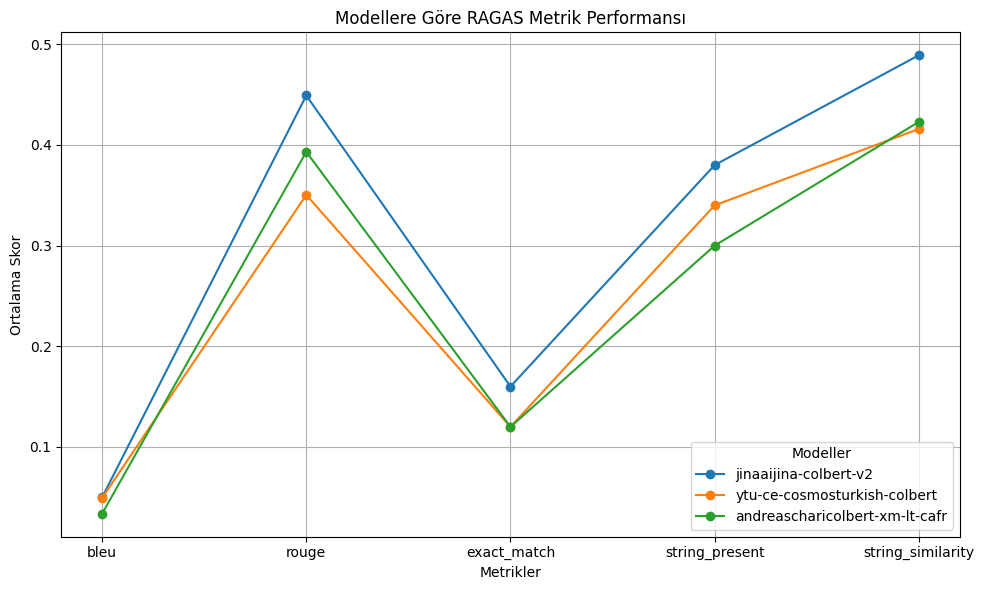

In [34]:
def plot_metrics_by_model(scores):
    metrics = ["bleu", "rouge", "exact_match", "string_present", "string_similarity"]
    metric_labels = {
        "bleu": "BLEU",
        "rouge": "ROUGE",
        "exact_match": "Exact Match",
        "string_present": "String Present",
        "string_similarity": "String Similarity"
    }

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, model in enumerate(scores["model"]):
        ax.plot(
            metrics, 
            [scores[metric][i] for metric in metrics], 
            marker="o", 
            label=model
        )
    
    ax.set_xlabel("Metrikler")
    ax.set_ylabel("Ortalama Skor")
    ax.set_title("Modellere Göre RAGAS Metrik Performansı")
    ax.legend(title="Modeller")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Çizgi grafiği: Metrikler X ekseninde, modeller çizgilerde
plot_metrics_by_model(scores)
